# Notes on Teaching Transformers Arithmetic

To learn more about transformers and LLMs, I tried reproducing the results from [Transformers Can Do Arithmetic with the Right Embeddings](https://arxiv.org/abs/2405.17399), an interesting paper on altering LLM architecture to allow more easily learning basic arithmetic.

The idea in the paper is to train a transformer on formulaic prompts like "27+34=61", with the goal of being able to generalize to Out Of Distribution (OOD) numbers. To achieve this, the authors use an approach which they call "abacus encoding":
:
1. Numbers are written with the least significant digit first rather than last (i.e. "one hundred and twenty-three plus four hundred and fifty-six" is written 321+654).
2. Digits are always tokenized as separate tokens. This is definitely _not_ the case with models like OpenAI's GPT series, with a substantial number of tokens in the language consisting of 2-digit or 3-digit numbers. This is presumably onpositionale reason otherwise quite intelligent LLMs are fairly bad at arithmetic: imagine having to learn _from context_ that `765` consists of the sequence of digits 7 6 5, or more famously [that `11` consists of 1 1](https://community.openai.com/t/why-9-11-is-larger-than-9-9-incredible/869824). It's remarkable they can do any kind of reasoning about numbers at all.
3. There is a special positional encoding for numbers, a collection of 100 learned weight vectors recording the position of the ith digit in a number. E.g. our 321+654 example would get encode as the sequence:
   * (Learned embedding of token "3") + (Learned abacus encoding vector at position 1)
   * (embedding of "2") + (abacus encoding at position 2)
   * (embedding of "1") + (abacus@3)
   * (embedding of "+") + (abacus@0)
   * (embedding of "6") + (abacus@1)
   * (embedding of "5") + (abacus@2)
   * (embedding of "4") + (abacus@3)
4. OK actually (3) won't allow generalization because if we only train on 20-digit numbers, the abacus encoding at position 21 would never get any gradient updates and would just be random noise. To get around that, abacus encoding actually picks a random offset value and uses that as the "start" of all numbers. E.g. in our `312+654` example, 3 and 6 might get the 39th abacus vector, 2 and 5 the 40th, etc.

They also use a "looped transformer" architecture, where a sequence of K transformer layers is "repeated" or "looped" N times, with the output of the last layer feeding back into the first layer. The idea is that this should eventually converge to a "fixed point" (i.e. looping more times yields the same output tensor. This allows economizing on the number of parameters in the model, while still allowing the network to be deep enough to show nontrivial behavior. There is some theoretical and empirical reasons this may be useful; they cite a few interesting papers:
1. [Looped Transformers as Programmable Computers](https://arxiv.org/abs/2301.13196), which gives a mechanism for building arbitrary circuits in a transformer. A fairly neat construction, though I haven't dived into this one.
2. [Looped Transformers are Better at Learning Learning Algorithms](https://arxiv.org/abs/2311.12424), which shows that looping a transformer can improve performance on a linear regression task. Not useful by itself since linear regression is solved by much faster algorithms, but as with this paper, it's suggestive that looped transformers may be useful for other kinds of reasoning.

They needed two tricks to make looping work:
1. Add the original input to the output at each loop. This presumably prevents the outputs decaying or blowing up to infinity, though then they needed to _not_ do that for multiplication.
2. When computing loss, run the input on a fixed number of loops and make a "convex combination" of that (cross-entropy) loss with the loss from a smaller random number of loops.

Then they train the network on a bunch of problem instances like `1+1=2` or `12+13=25`, up to 20 digits, with the number of digits being chosen at random, then the numbers being chosen at random to match that number of digits (i.e. each combination of digits is equally likely in the training data, rather than 81% of them consisting of twenty digit numbers).

Since the problem instances are themselves random (i.e. _cannot be predicted_), they "mask" the tokens up to the equals sign, so they don't add a bunch of noise with high loss values from failing to predict random input. In other words, they only train on next-token prediction _after_ the equals size.

## Results

They found that the models using abacus encoding were able to generalize to out-of-distribution numbers with high 90's accuracy. Most interestingly, they found that despite having a smaller number of parameters, the looped transformers performed somewhat better than one deep transformer, with two loops of eigth layers being the most performant among "effective depth 16" transformers. They were able to extend these results to some other operations, suggesting that abacus encoding may be helpful for some kinds of general algorithmic tasks.

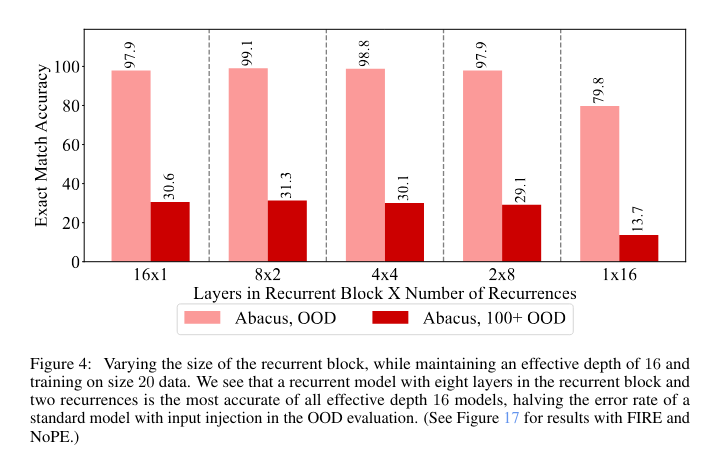

## Reproducing the results

One very cool thing about this research is that it's extremely modest in terms of GPU hardware required, and could probably even train on a CPU. The models are mostly quite small, and I was able to reproduce the addition results on my 8GB Nvidia 4060 GPU.

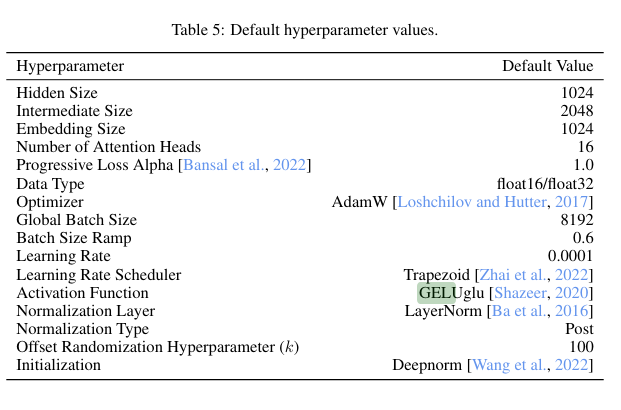

First, let's define the tokenizer:

In [1]:
class SimpleTokenizer:
    def __init__(self):
        self.alphabet = "0123456789-+*=$"  # $ is EOS token
        self.token_to_idx = {char: idx for idx, char in enumerate(self.alphabet)}
        self.idx_to_token = {idx: char for char, idx in self.token_to_idx.items()}
        self.vocab_size = len(self.alphabet)
        self.eos_token = "$"
        self.eos_id = self.token_to_idx["$"]
        self.digit_tokens = set("0123456789")
        self.digit_token_ids = set(
            self.token_to_idx[digit] for digit in self.digit_tokens
        )

    def encode(self, text, add_eos=True):
        """Convert string to list of token indices"""
        tokens = [self.token_to_idx[char] for char in text]
        if add_eos:
            tokens.append(self.eos_id)
        return tokens

    def decode(self, indices, remove_eos=True):
        """Convert list of token indices back to string"""
        if remove_eos and indices[-1] == self.eos_id:
            indices = indices[:-1]
        return "".join(self.idx_to_token[idx] for idx in indices)

    def is_digit(self, token_id):
        return token_id in self.digit_token_ids

assert SimpleTokenizer().encode('1234') == [1, 2, 3, 4, 14]

In [2]:
SimpleTokenizer().encode('1234$')

[1, 2, 3, 4, 14, 14]

In [3]:
import torch
import random
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import json
import subprocess
from tqdm import tqdm
import matplotlib.pyplot as plt


class AbacusPositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len=512, k=100):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        self.k = k
        self.positional_embeddings = nn.Embedding(max_seq_len, d_model)


    def find_numbers(self, tokens, tokenizer) -> list[list[int]]:
        """
        Returns a list of lists of indices of digits in each number.
        e.g. the tokens for `+12=34` would return [[1, 2], [4, 5]]
        """
        cur_span = []
        spans = []
        for i, token in enumerate(tokens):
            if tokenizer.is_digit(token):
                cur_span.append(i)
            else:
                if cur_span:
                    spans.append(cur_span)
                    cur_span = []
        if cur_span:
            spans.append(cur_span)
        return spans

    def forward(self, x, tokenizer, training=True):
        # Here we're given a "batch" of substrings of problem instances that will run
        # on the GPU in one go.
        batch_size, seq_len = x.shape
        device = x.device
        positions = torch.zeros(batch_size, seq_len, dtype=torch.long, device=device)
        for i in range(batch_size):
            spans = self.find_numbers(x[i].tolist(), tokenizer)
            longest_number = max(len(span) for span in spans)
            if training:
                # Choose a random offset to allow for generalization. Note that since
                # I created and embedding value for the entire context length, this can
                # in principle generalize more than in the paper. Bug? Feature?
                offset = random.randint(
                    0,
                    min(self.max_seq_len - longest_number, self.k - 1),
                )
            else:
                offset = 0

            for span in spans:
                for j, pos in enumerate(span, 1):
                    positions[i, pos] = offset + j
        embeddings = self.positional_embeddings(positions)
        return embeddings

Here we define an `nn.module` object, which is basically a tensor (multidimensional array) of weights with an activation function defined in `forward`. When a tensor is run through a `forward` pass in training mode, pytorch keeps track of of how it was computed, so that gradients can be computed relative to those weights. Then on the backward pass, torch is able to compute a gradient from a function that was implicitly implemented in python code (in this case computing an index for the embedding). If you were to write out the entire neural net for one training instance as a big algebraic expression these weights would be like free variables, so part of the dimension of the gradient. If you move a model to a "device" like "cuda" (Nvidia) or "mps" (MacOS), it will automatically use efficient drivers to compute the forward pass or gradient in parallel. Pretty cool!

For example:

In [4]:
import math
x = torch.tensor([2.0], requires_grad=True)
y = torch.tensor([3.0], requires_grad=True)
def f(x, y):
    return x ** 2 + torch.sin(y)


z = f(x, y)
z.backward()
print(f"Torch: {z.item()=} ; {x.grad.item()=} ; {y.grad.item()=}")
# Computing gradients by hand:
dz_dx, dz_dy = 2 * 2.0, math.cos(3.0)
print(f"Calc III: ∂z/∂x = {dz_dx} ; ∂z/∂y = {dz_dy}")

Torch: z.item()=4.141119956970215 ; x.grad.item()=4.0 ; y.grad.item()=-0.9899924993515015
Calc III: ∂z/∂x = 4.0 ; ∂z/∂y = -0.9899924966004454


Now let's define a transformer layer using the extremely cool but poorly packaged [flash-attn](https://github.com/Dao-AILab/flash-attention) module. I had almost no luck getting it to compile from source, and they didn't push wheels to pypi (presumably because different wheels are required for different versions of torch). I found it easiest to install by specifying a particular wheel to download, but ymmv:
```
flash-attn @ https://github.com/Dao-AILab/flash-attention/releases/download/v2.7.2.post1/flash_attn-2.7.2.post1+cu12torch2.5cxx11abiFALSE-cp312-cp312-linux_x86_64.whl
```

Use of flash attention differs from the paper, but should be faster and more memory efficient during training.

Note that this library requires 16-bit floats and cuda. The use of 16 bit floats in ML somehow feels extremely retro to me: more something you'd expect from a Sega Dreamcast than extremely advanced machine learning like modern LLMs. But you can't argue with results!

In [5]:
# Note: this class was like 95% written by Claude Sonnet 3.5.
from flash_attn import flash_attn_func


class FlashDecoderLayer(nn.Module):
    def __init__(
        self,
        d_model=1024,  # Model dimension from paper
        nhead=16,  # Number of attention heads from paper
        d_ff=2048,  # FFN intermediate dimension from paper
        dropout=0.0,  # They use no dropout during inference
        activation="gelu",
        layer_norm_eps=1e-12,
        use_input_injection=True,  # Add input to each layer as in paper
    ):
        super().__init__()
        assert d_model % nhead == 0, "d_model must be divisible by nhead"
        self.d_model = d_model
        self.nhead = nhead
        self.head_dim = d_model // nhead
        self.use_input_injection = use_input_injection

        # Self-attention
        self.qkv_proj = nn.Linear(d_model, 3 * d_model, bias=True)
        self.out_proj = nn.Linear(d_model, d_model, bias=True)

        # Normalization layers
        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps)

        # Feed-forward network
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU() if activation == "gelu" else nn.ReLU(),
            nn.Linear(d_ff, d_model),
        )

        self.dropout = nn.Dropout(dropout)
        self.scaling = float(self.head_dim) ** -0.5

    def forward(
        self,
        x: torch.Tensor,
        positions: torch.Tensor,
        input_injection: torch.Tensor = None,
        key_padding_mask=None,
        need_weights=False,
        causal=True,
    ):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model)
            positions: Position encodings from AbacusPositionalEncoder
            input_injection: Original input for skip connections
            key_padding_mask: Mask for padded tokens
            need_weights: Whether to return attention weights
            causal: Whether to apply causal masking
        """
        shortcut = x
        x = self.norm1(x)

        # Add input injection if enabled
        if self.use_input_injection and input_injection is not None:
            x = x + input_injection

        # Project to q, k, v
        batch_size, seq_len = x.shape[:2]
        qkv = self.qkv_proj(x)
        qkv = qkv.reshape(batch_size, seq_len, 3, self.nhead, self.head_dim)

        # Reshape positions to match head dimensions
        positions = positions.view(batch_size, seq_len, 1, self.nhead, self.head_dim)
        # Add positional embeddings to q, k only
        qkv[:, :, :2] = qkv[:, :, :2] + positions

        # Split into q, k, v
        q, k, v = qkv.unbind(dim=2)

        # Cast to fp16 for flash attention
        q = q.to(torch.float16)
        k = k.to(torch.float16)
        v = v.to(torch.float16)

        # Run flash attention
        attn_output = flash_attn_func(
            q,
            k,
            v,
            dropout_p=self.dropout.p if self.training else 0.0,
            softmax_scale=self.scaling,
            causal=causal,
        )

        # Cast back to original dtype
        attn_output = attn_output.to(x.dtype)

        # Project output
        attn_output = attn_output.reshape(batch_size, seq_len, self.d_model)
        output = self.out_proj(attn_output)

        # First residual connection
        x = shortcut + self.dropout(output)

        # FFN
        shortcut = x
        x = self.norm2(x)
        if self.use_input_injection and input_injection is not None:
            x = x + input_injection
        x = shortcut + self.dropout(self.ff(x))

        return x


## Some notes on terminology for LLM n00bs like myself

### "Attention Heads"

These are the fundamental insight of transformer architecture, consisting of three linear transformations (which seem to be called "projections" in ML literature whether or not they are "projections" in the mathematical sense): "queries", "keys" and "values".

Here `qkv_proj` is three square matrices "on top of each other", which take in `d_model=1024` vectors and output three concatenated vectors (query, key and value). When we "project" `qkv = self.qkv_proj(x)`, we end up with something that has one `3*d_model` vector for each (batch, sequence_position) pair, which gets reshaped and "unbound" into (Q,K,V) tensors. For a given batch and head index, that's three matrices of dimension `(seq_len, head_dim)`, and the flash attention does the following:
* Compute `Q@K^T` to get a matrix of shape `(seq_len, seq_len)`.
* Transform it with scaling and "softmax" (see below) to get _attention weights_. You can think of these as how much each token should attend to every other in the `d_head=64` dimensional subspace of the "values" space for that layer.
* Multiply those weights matrix by the "values" projection of that 64-d subspace to get a `head_dim` vector for each head.
* Apply "dropout" and "causal masking":
  * Dropout is a way to randomly exclude a subset (e.g. 20%) of weights from the gradient on each update to prevent overfitting the data and undergeneralizing. The NN needs to represent the same data in multiple compressed ways to survive dropout.
  * Causal masking forces attention weights to be zero for all "future" tokens further in the sequence, roughly reflecting the intuition that the model is reading the data in order.
* Concatenate the data for each head together to get a d_model vector.

Note: the "flash" part just means that computation is split up to do it in a more cache- and memory-efficient way for modern GPUs.

At a mathematical level, the Query-Key part for each head is equivalent to a _single_ linear map, since this is an "auto-regressive" model with "self-attention" (i.e. it's working on the same space as input and output). The names seem to come from "encoder-decoder" transformer archectures used for translation, where in the decoder, the key domain and query domain were different (e.g. corresponding to embeddings of English and French). See [this SO thread](https://stackoverflow.com/questions/56746191/why-are-the-matrices-in-bert-called-query-key-and-value). For autoregressive models like GPT, I presume separating them into two kinds of matrices has some advantage, e.g. better compatibility with hardware or empirically works better with gradient descent.

After that, we do the "feed forward" part, which:
* Does a linear map ("projects") into a higher dimensional (2048-dimensional) space
* Applies a nonlinear transform on the data (RELU/GELU, see below).
* Another linear map back into `d_model` space, and on to the next layer.

### "softmax"
A function which turns any list of numbers into a probability distribution, defined by:

$$ \left(x_0, x_1, \ldots x_k\right) \mapsto \frac{1}{\sum_{i=0}^k \exp(x_i)}\cdot \left(\exp(x_0), \exp(x_1), ... \exp(x_k)\right)$$

The name seems to come from the fact that if one of the arguments is significantly larger than the others, its softmax value will be near 1 and other values will be near 0. This is a smooth approximation of the function that maps a vector to one that is zero everywhere except at the largest index where it is 1 (sometimes called "argmax" or a "1-hot encoding" of the maximum index).

*Aside 1*: this has the nice property that it maps `-inf` values to `0`.

*Aside 2*: Softmax has an absolutely fundamental property when used with categorical outputs that generalizes logistic regression. When the final layer has a softmax and the model is trained with cross-entropy loss, then the earlier layer will learn to produce "logits" (outputs of a layer in a NN) which when passed to softmax approximate a probability distribution on the conditional probabilities of the target distribution. This can be interpreted as "confidence" in many domains. This will be useful when we get to "perplexity" below.

### ReLU (**Re**ctified **L**inear **U**nit) & GELU (**G**aussian **E**rror **L**inear **Unit**)

ReLU is a non-smooth, piecewise linear function defined by:

$$ x \mapsto \max(x, 0) $$

GELU is a function with a very similar-looking graph, but has some nonzero gradient below 0. It's defined as $x\mapsto x\cdot \phi(x)$, where $\phi$ is the cumulative distribution function of the normal distribution. See [this Stackexchange answer](https://datascience.stackexchange.com/a/49535) where the graph below is from.

Both functions give some threshold "nonlinearity", and a gradient that allows "muting" some nodes in the network. ReLU is like a hard switch where once it gets to 0. No gradients "from below" will have an effect on a zeroed out ReLU activation, while GELU provides a way of turning nodes "back on" since it has nonzero gradients below 0. In pytorch, neither function has any learnable parameters.
#### Graph of GELU:

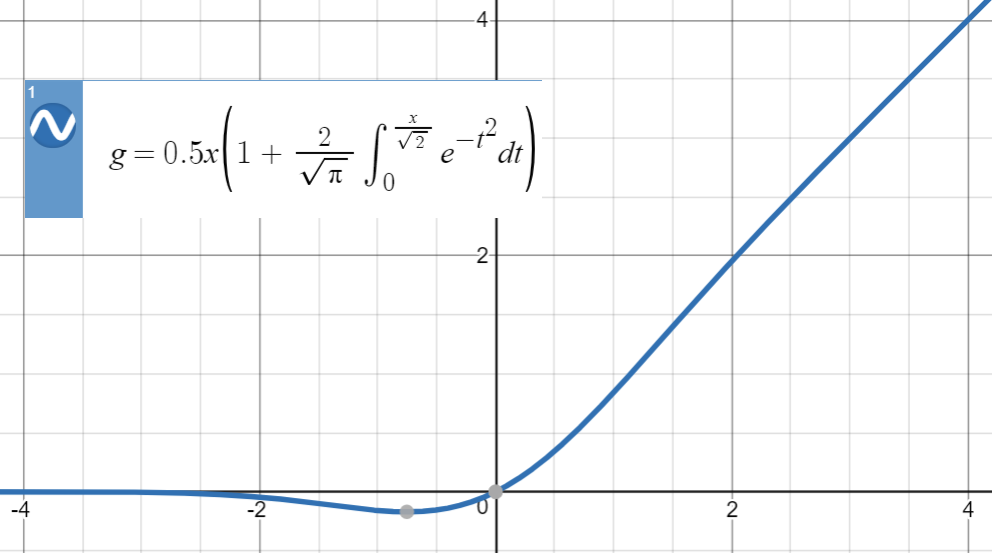

# Loop It!

This is somewhat more straightforward. We define a stack of layers with a given size and a max number of loops. We'll choose 8 layers deep and 2 loops, which is what the paper found worked best. Then in `forward`, we loop that number of times, or some smaller number of times for the "random loop" part.

In [6]:
class FlashDecoderStack(nn.Module):
    def __init__(
        self,
        recurrent_block_size=1,  # Number of unique layers
        num_recurrences=16,  # Number of times to reuse layers
        **layer_kwargs,
    ):
        super().__init__()
        self.recurrent_block_size = recurrent_block_size
        self.num_recurrences = num_recurrences

        # Create the recurrent block of layers
        self.layers = nn.ModuleList(
            [FlashDecoderLayer(**layer_kwargs) for _ in range(recurrent_block_size)]
        )

    def forward(self, x, positions, num_recurrences=None, **kwargs):
        # Store original input for input injection
        input_injection = x if self.layers[0].use_input_injection else None
        if num_recurrences is None:
            num_recurrences = self.num_recurrences
        # Apply layers with recurrence
        for _ in range(num_recurrences):
            for layer in self.layers:
                x = layer(x, positions, input_injection=input_injection, **kwargs)
        return x

And finally, we define the full transformer module. Note that in the loss computation, we don't need to apply softmax first, since torch's [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) accepts either a probability distribution _or_ a list of target class IDs (in which case it does the equivalent of log softmax to compute the loss).

In [7]:
class ArithmeticTransformer(nn.Module):
    def __init__(
        self,
        d_model=1024,
        nhead=16,
        recurrent_block_size=16,
        num_recurrences=1,
        d_ff=2048,
        dropout=0.0,
        max_seq_len=512,
    ):
        super().__init__()
        self.tokenizer = SimpleTokenizer()
        vocab_size = self.tokenizer.vocab_size
        self.token_embeddings = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = AbacusPositionalEncoder(d_model, max_seq_len)
        self.decoder_stack = FlashDecoderStack(
            recurrent_block_size=recurrent_block_size,
            num_recurrences=num_recurrences,
            d_model=d_model,
            nhead=nhead,
            d_ff=d_ff,
            dropout=dropout,
        )
        self.output_projection = nn.Linear(d_model, vocab_size)
        self.max_seq_len = max_seq_len

    def forward(self, input_ids, labels=None, num_recurrences=None):
        x = self.token_embeddings(input_ids)
        pos = self.pos_encoder(input_ids, self.tokenizer)
        x = self.decoder_stack(
            x,
            positions=pos,
            key_padding_mask=None,
            causal=True,
            num_recurrences=num_recurrences,
        )
        logits = self.output_projection(x)
        if labels is not None:
            # Shift labels and logits
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()

            # Calculate loss only on answer tokens
            loss = F.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                ignore_index=-100,  # Ignore padded tokens
            )

            return {"loss": loss, "logits": logits}

        return {"logits": logits}



## Generate and encode data:
This is a small hack around the torch `Dataset` class, overridding `__getitem__` to return a tokenized problem instance with a random number of digits between 1 and 20. Note that we use `-100` for tokens we want to mask (up to the = and after the $), as defined in the `ignore_index` parameter above.

In [8]:
class ArithmeticDataset(Dataset):
    def __init__(self, max_digits=20, num_samples=20000000):
        self.tokenizer = SimpleTokenizer()
        self.max_digits = max_digits
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def generate_number(self, num_digits):
        """Generate a number with exactly num_digits digits"""
        if num_digits == 1:
            return random.randint(0, 9)
        return random.randint(
            0 if num_digits == 1 else 10 ** (num_digits - 1),
            (10**num_digits) - 1,
        )

    def __getitem__(self, idx):
        # Sample lengths uniformly
        len1 = random.randint(1, self.max_digits)
        len2 = random.randint(1, self.max_digits)

        # Generate numbers with exact lengths
        num1 = self.generate_number(len1)
        num2 = self.generate_number(len2)

        # Create the problem string (reversed order as per paper)
        problem = str(num1)[::-1] + "+" + str(num2)[::-1] + "="
        answer = str(num1 + num2)[::-1]

        # Convert to tokens
        input_tokens = self.tokenizer.encode(problem, add_eos=False)
        assert (
            input_tokens[-1] == self.tokenizer.token_to_idx["="]
        ), "Problem must end with ="
        # Create mask labels with -100 for all positions up to and including =
        labels = [-100] * len(input_tokens)
        target_tokens = self.tokenizer.encode(answer)
        assert target_tokens[-1] == self.tokenizer.eos_id, "Answer must end with EOS"
        input_tokens.extend(target_tokens)
        labels.extend(target_tokens)

        # Calculate maximum possible sequence length
        max_seq_len = (self.max_digits * 2) + 2  # Two numbers + '+' and '=' signs
        max_answer_len = (
            self.max_digits + 1 + 1
        )  # Max answer length (1 digit more than max digits) + EOS
        total_seq_len = max_seq_len + max_answer_len

        # Pad input_tokens to max_seq_len
        input_tokens = input_tokens + [self.tokenizer.eos_id] * (
            total_seq_len - len(input_tokens)
        )

        # Pad labels to total_seq_len
        labels.extend([-100] * (total_seq_len - len(labels)))
        return {
            "input_ids": torch.tensor(input_tokens),
            "labels": torch.tensor(labels),
        }

We can examine what one of these training examples looks like:

In [9]:
dataset = ArithmeticDataset(max_digits=5)
instance = dataset[0]
list(zip(dataset.tokenizer.decode(instance["input_ids"].tolist()), instance["labels"].tolist()))

[('0', -100),
 ('2', -100),
 ('2', -100),
 ('+', -100),
 ('8', -100),
 ('2', -100),
 ('3', -100),
 ('3', -100),
 ('=', -100),
 ('8', 8),
 ('4', 4),
 ('5', 5),
 ('3', 3),
 ('$', 14),
 ('$', -100),
 ('$', -100),
 ('$', -100),
 ('$', -100)]

## Train!

In [10]:
device = torch.device("cuda")  # must use cuda because of flash-attn
assert torch.cuda.is_available()
torch.cuda.empty_cache()
model = ArithmeticTransformer(recurrent_block_size=1, num_recurrences=16).to(device)

At this point, the model has been initialized with _random_ weights, so it should do no better than randomly generating strings on the tokenizer alphabet, which is indeed what we see:

In [11]:
from statistics import mean
from math import exp

def generate_answer(model, num1: int, num2: int, max_digits=150):
    """
    Compute the answer outputted by the model along with the perplexity of the correct answer.
    """
    tokenizer = model.tokenizer
    problem = str(num1)[::-1] + "+" + str(num2)[::-1] + "="
    problem_tokens: list[int] = tokenizer.encode(problem, add_eos=False)
    input_tokens = list(problem_tokens)
    answer = str(num1 + num2)[::-1] + "$"
    answer_tokens = tokenizer.encode(answer, add_eos=False)
    full_statement_tokens = torch.tensor(input_tokens + answer_tokens).unsqueeze(0).to(device)
    generated_tokens = []
    correct_logprobs = []
    model.eval()  # as opposed to model.train()
    tokens_so_far = len(input_tokens)
    with torch.no_grad():  # disables gradient tracking
        for _ in range(max_digits):
            outputs = model(torch.tensor(input_tokens).unsqueeze(0).to(device))
            next_token_logits = outputs["logits"][0, -1, :]
            predicted_token = next_token_logits.argmax().item()
            if predicted_token == tokenizer.eos_id:
                break
            else:
                generated_tokens.append(predicted_token)
                input_tokens.append(predicted_token)
        for i, correct_token in enumerate(answer_tokens, 0):
            outputs = model(full_statement_tokens[:,:len(problem_tokens)+i])
            next_token_logits = outputs["logits"][0, -1, :]
            logprobs = nn.LogSoftmax(dim=0)(next_token_logits)
            correct_logprobs.append(logprobs[correct_token].item())
    perplexity_of_correct_answer = exp(-mean(correct_logprobs))
    return (tokenizer.decode(generated_tokens, remove_eos=False)[::-1], perplexity_of_correct_answer)


def check_answer(model, num1, num2, max_digits=150):
    gen_answer, correct_answer_perplexity = generate_answer(model, num1, num2)
    correctness = "correct" if str(num1+num2) == gen_answer else "incorrect"
    print(f"Output {correctness}:\n\t{num1}+{num2}={gen_answer}\n\t{correct_answer_perplexity=}")


print(check_answer(model, 1, 1))

Output incorrect:
	1+1=================
	correct_answer_perplexity=7775.605965354573
None


Now we want to do some training on random instances, matching the 20M examples from the paper.


Saved model to ./model_0.pt
Batch 0, loss=9.62136459350586 t=0.8s
Output incorrect:
	1+1==================
	correct_answer_perplexity=14581.836010020208
Output incorrect:
	57+24===================
	correct_answer_perplexity=74972.80264434294
Output incorrect:
	999999+8888==================
	correct_answer_perplexity=199.9132414846273
Output incorrect:
	789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789789+1212121212121212121212121212121212121212===========================
	correct_answer_perplexity=1637.2590761673289
...................................................................................................
Saved model to ./model_5000.pt
Batch 5000, loss=0.023050425574183464 t=2334.2s
Output incorrect:
	1+1=12
	correct_answer_perplexity=5985.781926094305
Output correct:
	57+24=81
	correct_answer_perplexity=1.1549736380920936
Output incorrect:
	999999+8888=0008887
	correct_answer_pe

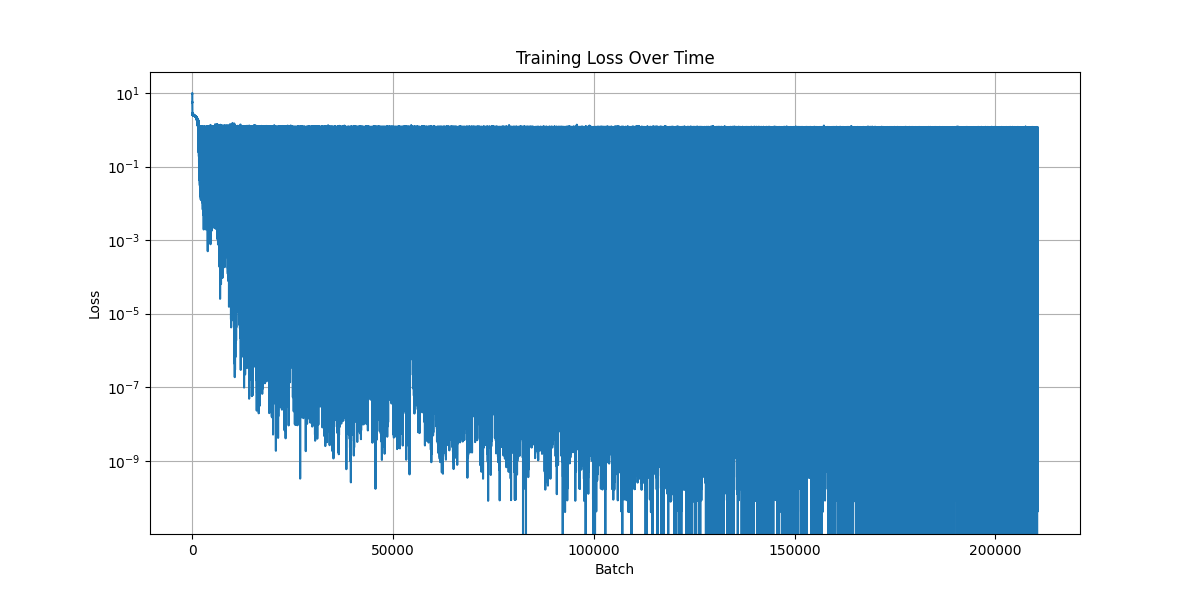

In [12]:
import time
import random
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def train_arithmetic_model(
    model,
    max_digits=20,
    num_samples=20_000_000,
    batch_size=95,
    num_workers=4,
    learning_rate=1e-4,
    max_batches=None,
    save_interval=5000,
    device="cuda",
    save_path="./model_{}.pt"
):
    
    t0 = time.time()
    dataset = ArithmeticDataset(
        max_digits=max_digits,
        num_samples=num_samples,
    )
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scaler = torch.amp.GradScaler(device)
    losses = []
    train_tokens = 0
    model.train()
    
    for batch_num, batch in enumerate(dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        with torch.amp.autocast(device):
            output_full = model(**batch)
            loss_full = output_full["loss"]
            
            random_recur = random.randint(1, model.decoder_stack.num_recurrences)
            if random_recur != model.decoder_stack.num_recurrences:
                output_partial = model(**batch, num_recurrences=random_recur)
                loss_partial = output_partial["loss"]
                loss = 0.5 * (loss_full + loss_partial)
            else:
                loss = loss_full
                
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            losses.append(loss.item())
            train_tokens += torch.sum(batch["labels"] != -100).item()
        
        if (batch_num % save_interval == 0):
            # Save model checkpoint
            save_file = save_path.format(batch_num)
            torch.save(model.state_dict(), save_file)
            print(f"\nSaved model to {save_file}")
            
            # Print progress and check answers
            print(f"Batch {batch_num}, loss={losses[-1]} t={time.time()-t0:0.1f}s")
            check_answer(model, 1, 1)
            check_answer(model, 57, 24)
            check_answer(model, 999999, 8888)
            check_answer(model, int('789' * 50), int('12' * 20))
        elif batch_num % 50 == 0:
            print(".", end="")
            
        if max_batches is not None and batch_num >= max_batches:
            # Save final model
            save_file = save_path.format(batch_num)
            torch.save(model.state_dict(), save_file)
            print(f"\nSaved final model to {save_file}")
            break
    plt.figure(figsize=(12, 6))
    plt.plot(losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    
    # Save the plot
    plt.savefig('training_losses.png')
    plt.close()
    # Clean up gradients and memory
    model.zero_grad(set_to_none=True)
    del optimizer
    del scaler
    torch.cuda.empty_cache()
    
    return losses

losses = train_arithmetic_model(
    model,
    max_digits=20,
    num_samples=20_000_000,
    batch_size=95,
    save_interval=5000
)
from IPython.display import Image, display
display(Image('training_losses.png'))

## More notes on terminology:

### [Perplexity](https://en.wikipedia.org/wiki/Perplexity#Perplexity_of_a_probability_model), or "that's so random"
This is an average measure of how unlikely a piece of text is, defined as the reciprocal of the geometric mean of token probabilities (conditioned on previous token probabilities) in that piece of text:

$$ \left(\prod_{i=1}^n p\left(t_i|t_1\ldots t_{i-1}\right) \right)^{-1/n} $$

Text with 100% probability of each token has a perplexity of 1. Any sequence of H (heads) and T (tails) fair coin flips would have a perplexity of $2=\frac{1}{1/2}$. Low probability text has much higher perplexity.

It's often computed from log probabilities for numerical stability, or because that's what e.g. OpenAI's API endpoints return.  There the formula is:

$$ \exp\left( - \frac{1}{n}\sum_{i=1}^n \log\left(p\left(t_i|t_1\ldots t_{i-1}\right)\right)\right) $$

### `torch.amp.autocast`

"AMP" stands for "Automatic Mixed Precision". This prevents cuda mixed precision errors if we try to add a float16 to a float32.

## OOD numbers

Now we can examine out-of-distribution numbers (more than 20 digits) to see how well it does. To limit the computation time, we'll only look at pairs of numbers of the same length.

In [28]:
# device = torch.device("cuda")  # must use cuda because of flash-attn
# assert torch.cuda.is_available()

# model = ArithmeticTransformer(recurrent_block_size=8, num_recurrences=2)
# model.load_state_dict(torch.load('./model_50000.pt', weights_only=True))
# model.load_state_dict(torch.load('./run_50k.pt', weights_only=True))
# data = torch.load('./runs/20241226_1605/model_final.pt', weights_only=True)
# model.load_state_dict(torch.load('./runs/20241226_1605/model_final.pt', weights_only=True))
# model = model.to(device)
import random
import torch

def run_batch(model, digits1, digits2, n_batch, num_recurrences=None, seed=None) -> torch.tensor:
    model.eval()
    torch.cuda.empty_cache()
    if seed is not None:
        randint = random.Random(seed).randint
    else:
        randint = random.randint
        
    with torch.no_grad():
        instances = [
            (
                randint(0 if digits1 == 1 else 10**(digits1-1), 10**digits1-1),
                randint(0 if digits2 == 1 else 10**(digits2-1), 10**digits2-1),
            )
            for _ in range(n_batch)
        ]
        strings = [
            f"{str(k1)[::-1]}+{str(k2)[::-1]}=" for k1, k2 in instances
        ]
        batch = torch.tensor([
            model.tokenizer.encode(instance, add_eos=False) for instance in strings
        ]).to(device)
        for iteration in range(max(digits1, digits2) + 2):  # +2 for potential carry
            logits = model(batch, num_recurrences=num_recurrences)["logits"]
            last_token_logits = logits[:, -1, :]
            next_tokens = torch.argmax(last_token_logits, dim=-1).unsqueeze(-1)
            batch = torch.cat([batch, next_tokens], dim=-1)
        results = [
            model.tokenizer.decode(sequence, remove_eos=False)
            for sequence in batch.tolist()
        ]
        
        return results        


%time lgs = run_batch(model, 3, 5, 500)
torch.cuda.empty_cache()

CPU times: user 1.69 s, sys: 80.2 ms, total: 1.77 s
Wall time: 1.77 s


In [29]:
from typing import NamedTuple


class EvalResult(NamedTuple):
    total: int
    correct: int


import re


def eval_batch_results(results: list[str]) -> EvalResult:
    correct = 0
    for result in results:
        match = re.match(r"(\d+)[+](\d+)=(\d+)[$]", result)
        if match:
            n1, n2, answer = [int(x[::-1]) for x in match.groups()]
            if n1 + n2 == answer:
                correct += 1
    return EvalResult(total=len(results), correct=correct)
        


eval_batch_results(run_batch(model, 20, 20, 100, seed=1))

EvalResult(total=100, correct=100)

In [42]:
def evaluate_digit_combinations(model, n_digits, seed=None, num_recurrences=16, n_batch=100):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from IPython.display import clear_output
    import time

    # Initialize results matrix with NaN
    results = np.full((n_digits, n_digits), np.nan)

    def plot_current_results(results, current_size):
        plt.figure(figsize=(15, 12))
        # Create a masked array to show only computed values (non-NaN)
        masked_results = np.ma.masked_array(results, mask=np.isnan(results))
        hm = sns.heatmap(masked_results,
                         xticklabels=range(1, n_digits+1),
                         yticklabels=range(1, n_digits+1),
                         cmap='viridis',
                         vmin=0,
                         vmax=1)
        plt.gca().invert_yaxis()
        plt.xlabel('Number of digits (second number)')
        plt.ylabel('Number of digits (first number)')
        plt.title(f'Addition Accuracy by Number of Digits (Computing {current_size}x{current_size} square)')
        plt.colorbar(hm.collections[0], label='Accuracy')
        plt.tight_layout()
        plt.show()

    # Run evaluation in expanding squares
    start_time = time.time()
    total_computed = 0

    for size in range(1, n_digits + 1):
        for i in range(size):  # Row index
            for j in range(size):  # Column index
                if not np.isnan(results[i, j]):
                    continue
                batch_results = run_batch(model, 
                                        digits1=i+1, 
                                        digits2=j+1, 
                                        n_batch=n_batch,
                                        num_recurrences=num_recurrences,
                                        seed=seed)
                eval_result = eval_batch_results(batch_results)
                accuracy = eval_result.correct / eval_result.total
                results[i, j] = accuracy
                total_computed += 1
                print(f"digits1={i+1}, digits2={j+1}: accuracy={accuracy:.2f}")
                elapsed_time = time.time() - start_time
                progress = total_computed / (n_digits * n_digits)
                if progress > 0:
                    estimated_total = elapsed_time / progress
                    remaining = estimated_total - elapsed_time
                    print(f"Estimated time remaining: {remaining/60:.1f} minutes")
        
        # After each square is complete, clear output and show current progress
        clear_output(wait=True)
        plot_current_results(results, size)
        print(f"Completed {size}x{size} square")
        print(f"Current average accuracy: {np.nanmean(results):.3f}")
        print(f"Best performance so far: {np.nanmax(results):.3f}")
        print(f"Worst performance so far: {np.nanmin(results):.3f}")
    
    return results

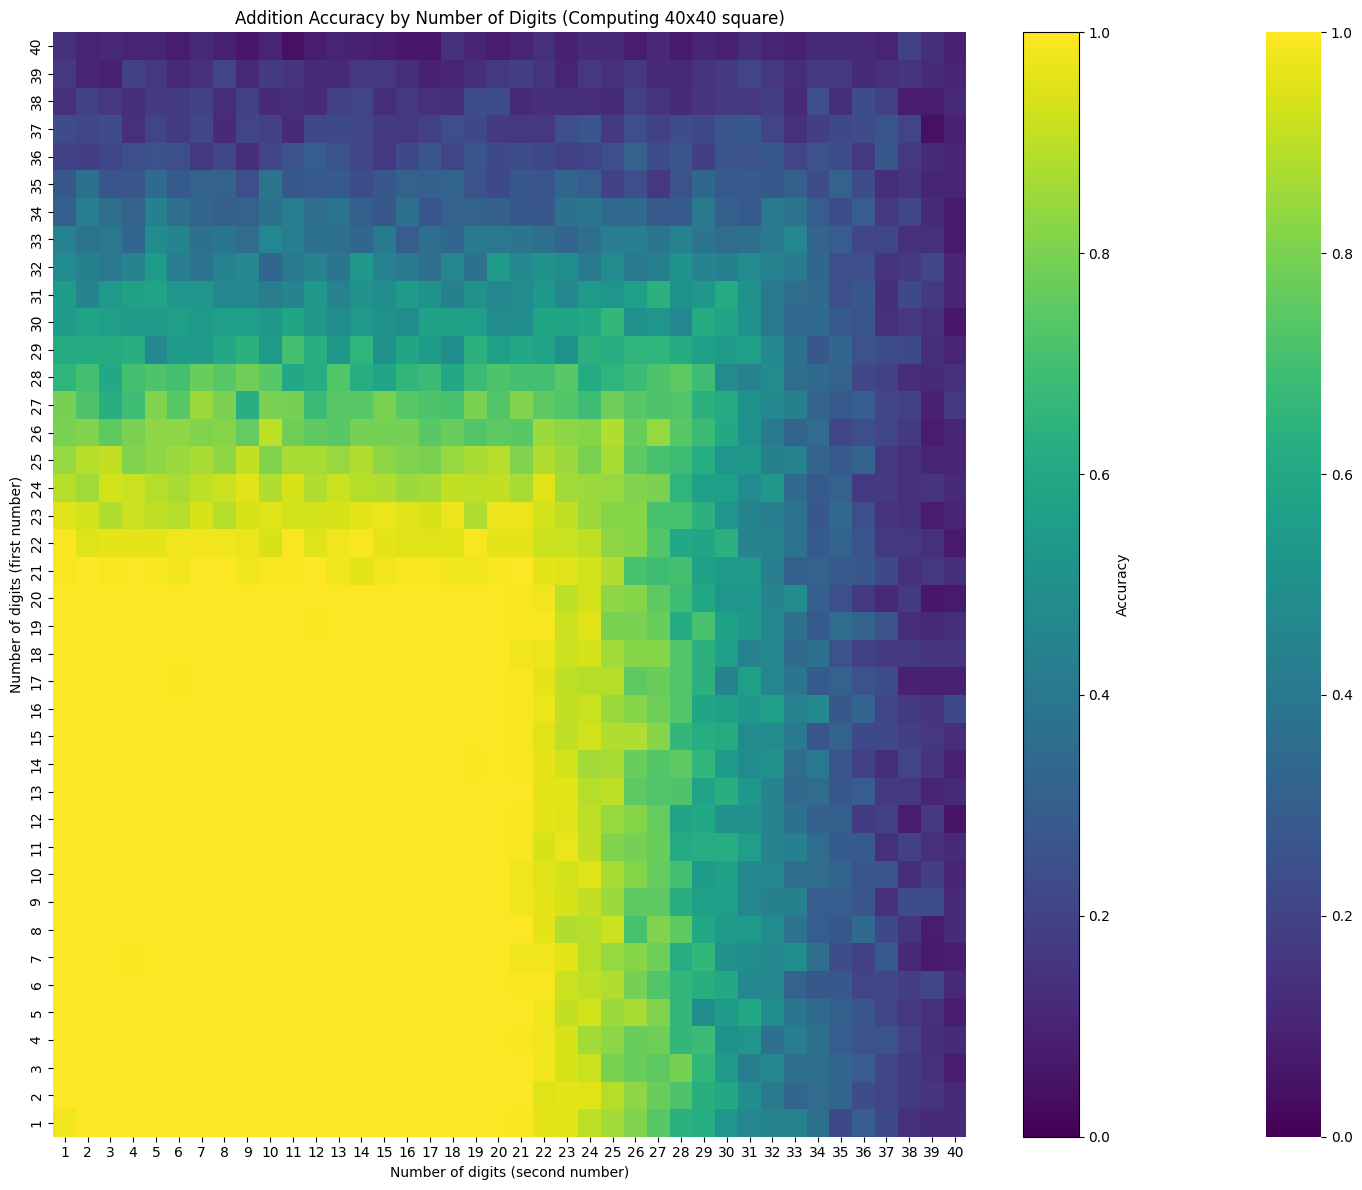

Completed 40x40 square
Current average accuracy: 0.613
Best performance so far: 1.000
Worst performance so far: 0.040


array([[0.98, 1.  , 1.  , ..., 0.14, 0.12, 0.12],
       [1.  , 1.  , 1.  , ..., 0.17, 0.15, 0.11],
       [1.  , 1.  , 1.  , ..., 0.17, 0.14, 0.08],
       ...,
       [0.14, 0.19, 0.16, ..., 0.08, 0.08, 0.11],
       [0.16, 0.1 , 0.09, ..., 0.15, 0.12, 0.1 ],
       [0.14, 0.1 , 0.11, ..., 0.19, 0.13, 0.09]], shape=(40, 40))

In [45]:
evaluate_digit_combinations(model, n_digits=40, seed=42, num_recurrences=16, n_batch=100)

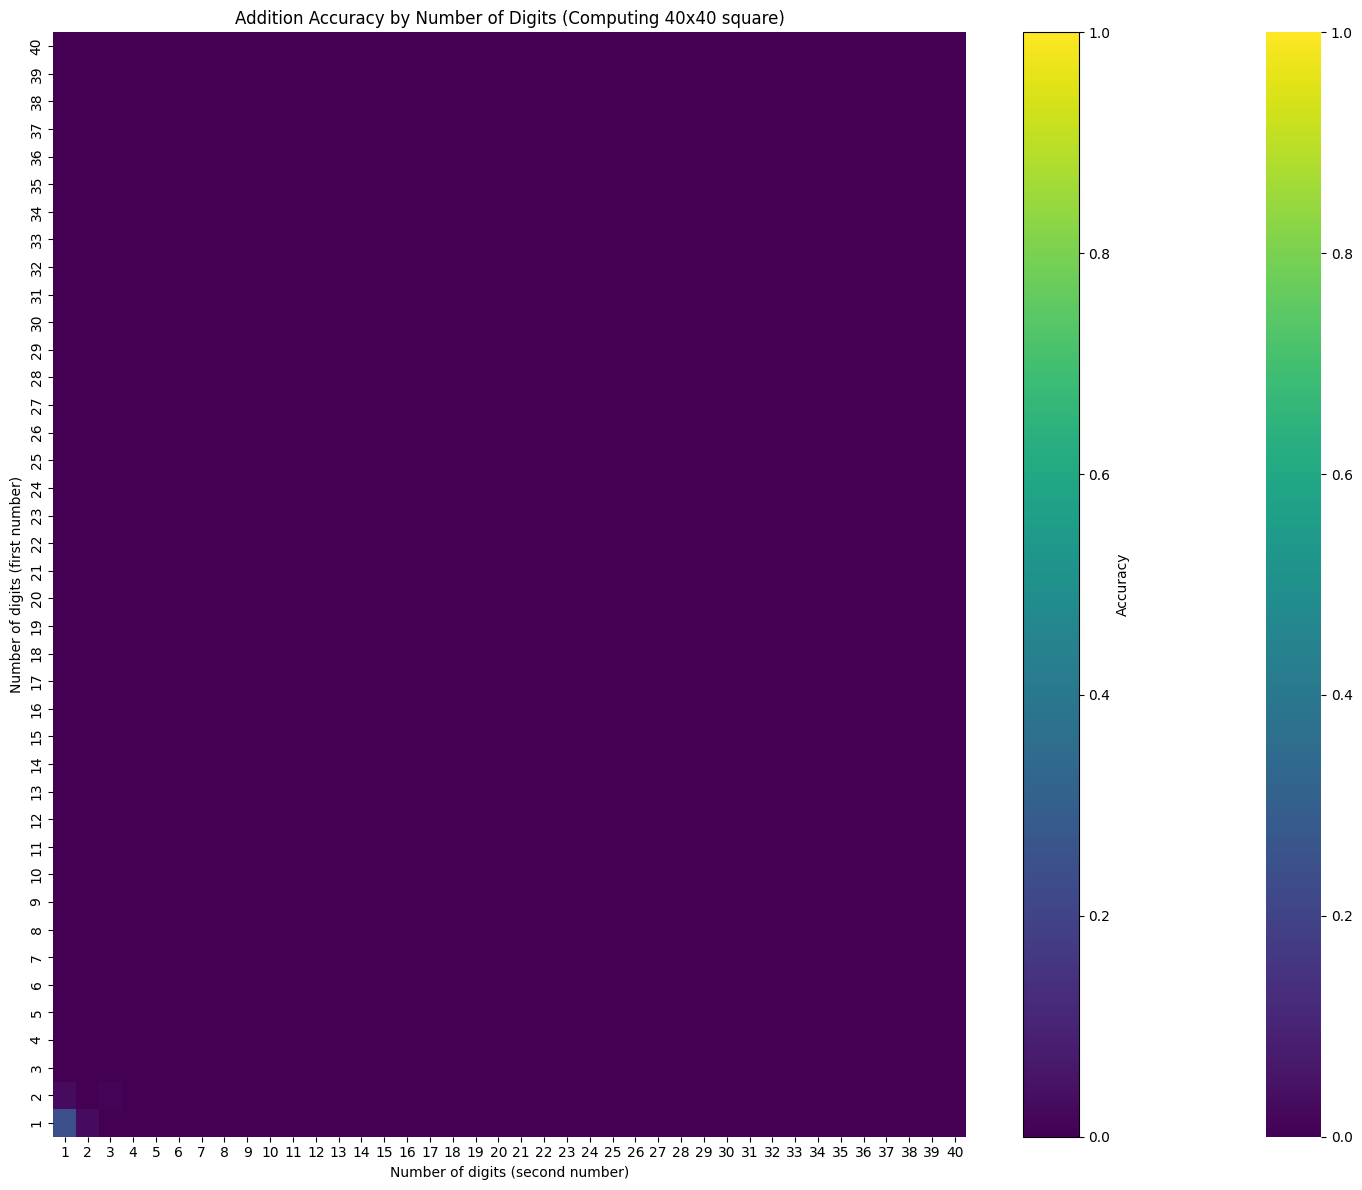

Completed 40x40 square
Current average accuracy: 0.000
Best performance so far: 0.240
Worst performance so far: 0.000


array([[0.24, 0.03, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.03, 0.  , 0.01, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]], shape=(40, 40))

In [46]:
evaluate_digit_combinations(model, n_digits=40, seed=42, num_recurrences=1, n_batch=100)

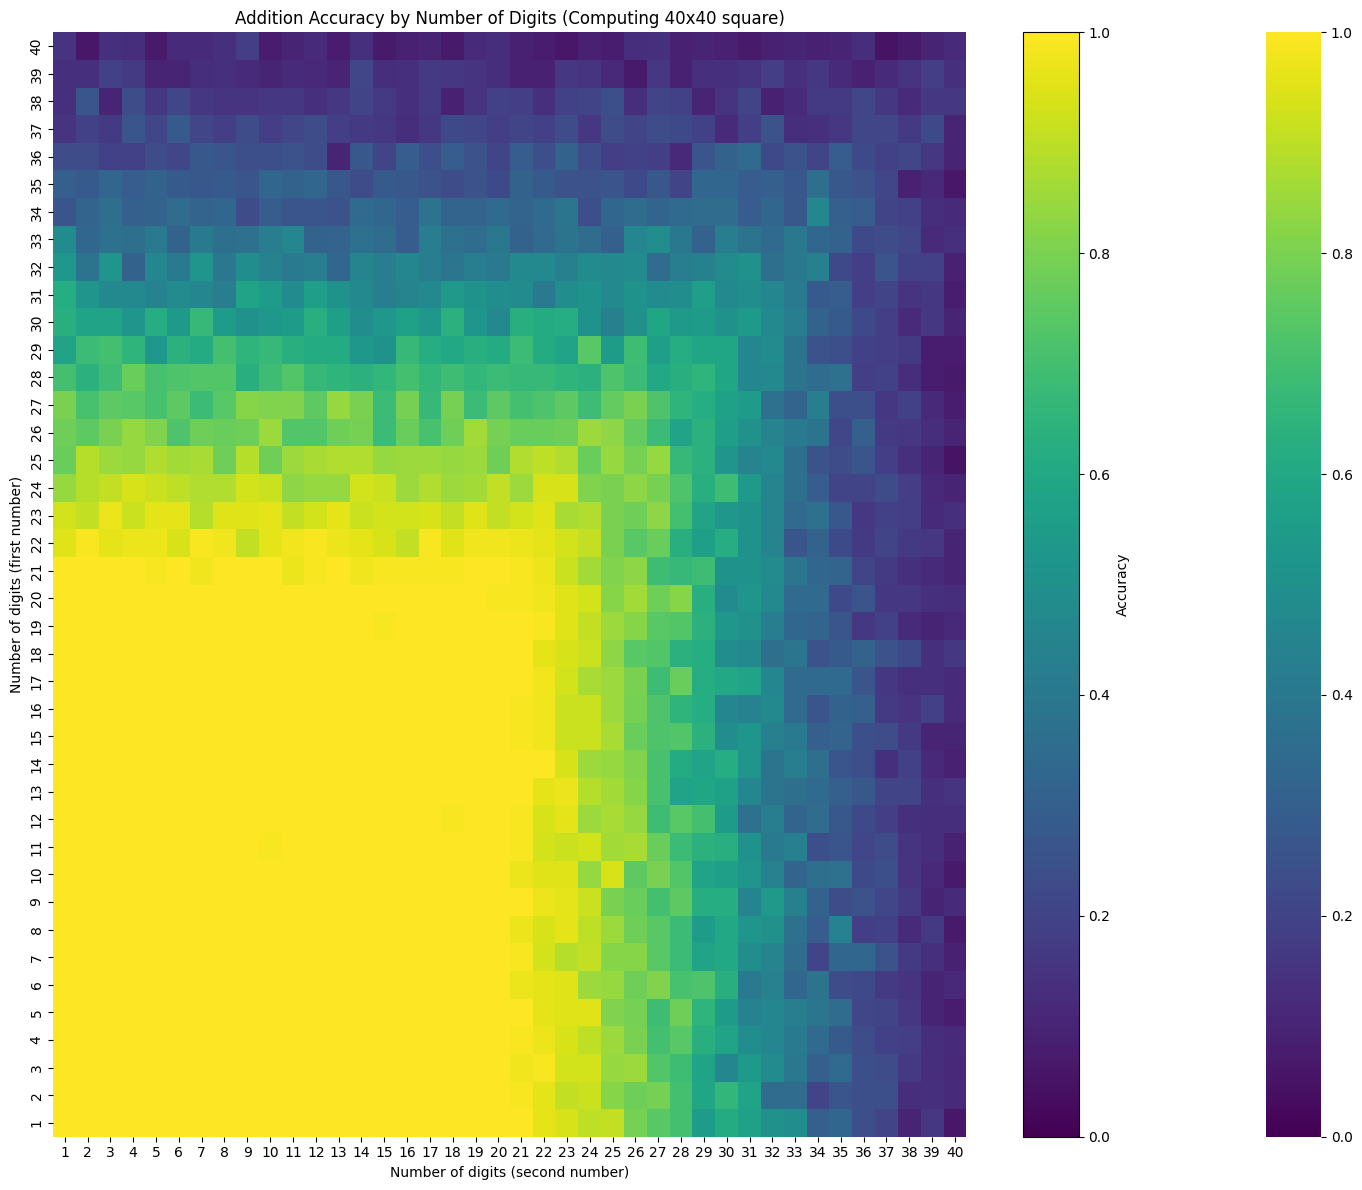

Completed 40x40 square
Current average accuracy: 0.611
Best performance so far: 1.000
Worst performance so far: 0.050


array([[1.  , 1.  , 1.  , ..., 0.1 , 0.16, 0.06],
       [1.  , 1.  , 1.  , ..., 0.13, 0.14, 0.12],
       [1.  , 1.  , 1.  , ..., 0.17, 0.13, 0.11],
       ...,
       [0.14, 0.26, 0.1 , ..., 0.12, 0.16, 0.16],
       [0.14, 0.14, 0.19, ..., 0.15, 0.18, 0.14],
       [0.15, 0.06, 0.14, ..., 0.07, 0.1 , 0.12]], shape=(40, 40))

In [47]:
evaluate_digit_combinations(model, n_digits=40, seed=42, num_recurrences=8, n_batch=100)

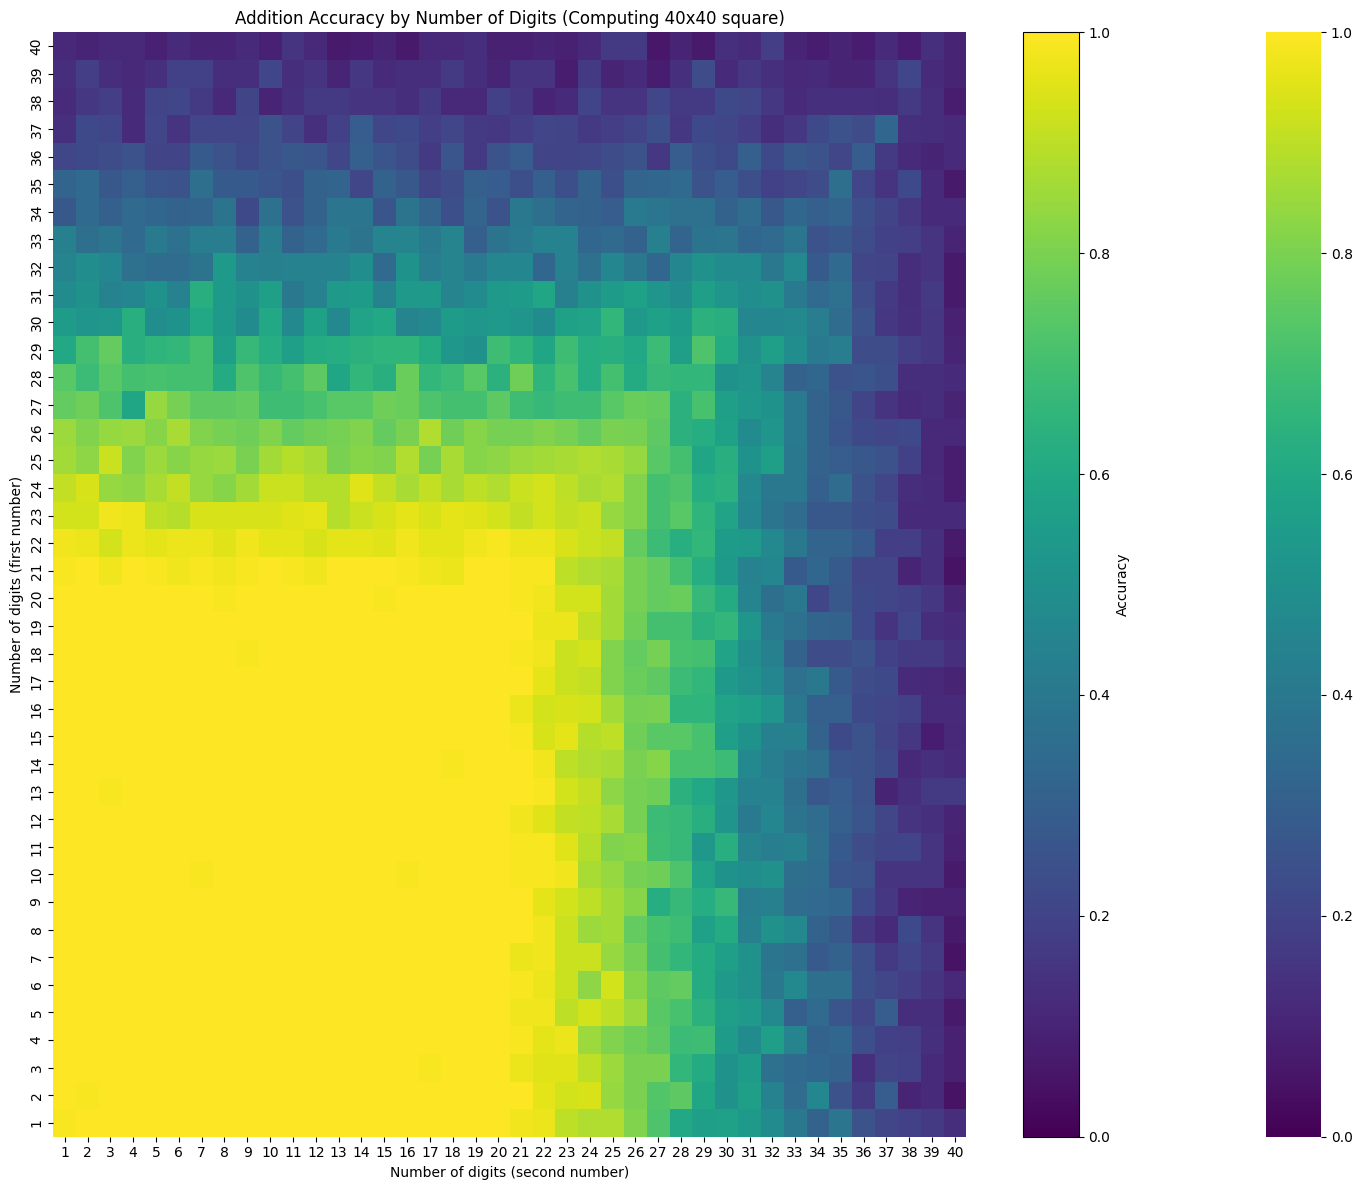

Completed 40x40 square
Current average accuracy: 0.613
Best performance so far: 1.000
Worst performance so far: 0.050


array([[0.99, 1.  , 1.  , ..., 0.19, 0.17, 0.13],
       [1.  , 0.99, 1.  , ..., 0.1 , 0.12, 0.05],
       [1.  , 1.  , 1.  , ..., 0.19, 0.12, 0.09],
       ...,
       [0.12, 0.16, 0.18, ..., 0.17, 0.13, 0.08],
       [0.13, 0.18, 0.13, ..., 0.21, 0.12, 0.1 ],
       [0.11, 0.1 , 0.11, ..., 0.08, 0.14, 0.1 ]], shape=(40, 40))

In [48]:
evaluate_digit_combinations(model, n_digits=40, seed=42, num_recurrences=32, n_batch=100)

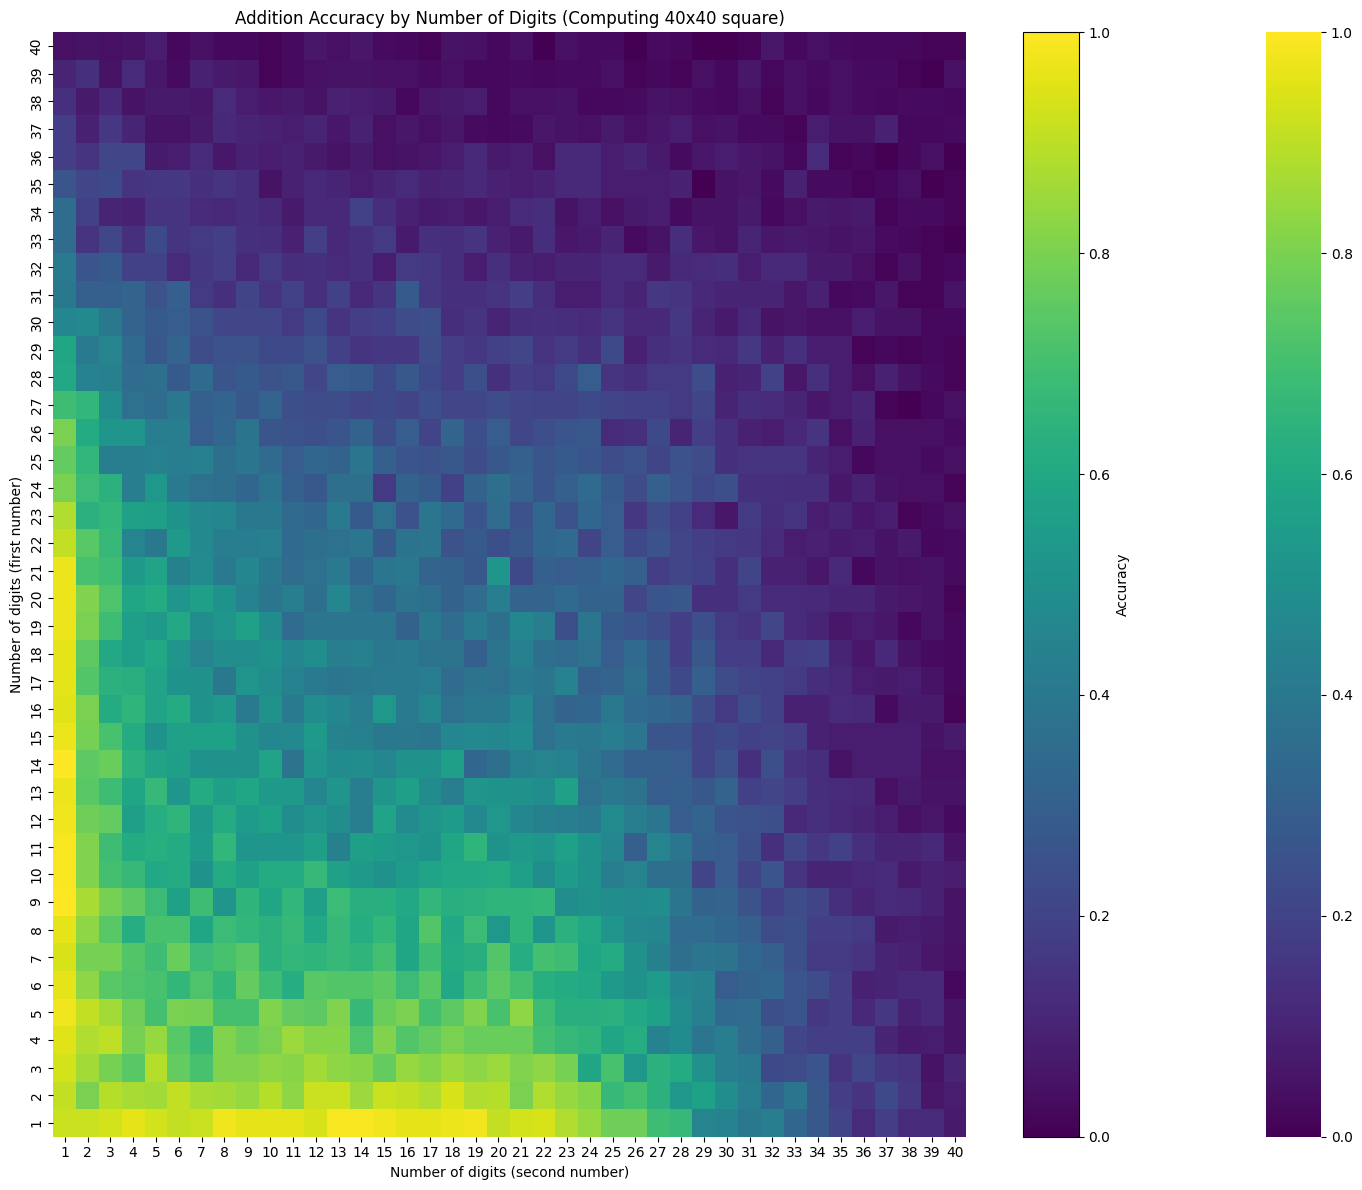

Completed 40x40 square
Current average accuracy: 0.320
Best performance so far: 1.000
Worst performance so far: 0.000


array([[0.92, 0.92, 0.93, ..., 0.12, 0.12, 0.07],
       [0.91, 0.8 , 0.89, ..., 0.16, 0.06, 0.08],
       [0.93, 0.86, 0.79, ..., 0.15, 0.05, 0.1 ],
       ...,
       [0.14, 0.07, 0.11, ..., 0.03, 0.03, 0.02],
       [0.1 , 0.14, 0.05, ..., 0.01, 0.  , 0.04],
       [0.04, 0.05, 0.04, ..., 0.02, 0.01, 0.01]], shape=(40, 40))

In [49]:
evaluate_digit_combinations(model, n_digits=40, seed=42, num_recurrences=2, n_batch=100)

In [50]:
torch.cuda.empty_cache()

## Overall notes

My attempt to reproduce the results of the paper was only partly successful. We saw it learn arithmetic on the train distribution, saw some OOD generalization (though not all that much), and observed variable accuracy at different loop numbers. 

However, the overall accuracy was worse than in the paper. I think this comes down to two things:
1. I tried creating abacus positional encoding vectors for the entire context length. This meant each encoding vector got fewer gradients adjusting it than it did in the paper.
2. I only ran the single-layer looped 16 times case, which was the worst performer in the paper. It was also much faster on my GPU. I did few training runs on 8x2, but didn't rigorously record them because various other things were broken at that point. I think for future projects, I'll try to get the code basically working on small models locally and send to cloud GPUs for larger training runs. The RTX 4060 can do something like [15 TFLOP/s](https://www.techpowerup.com/gpu-specs/geforce-rtx-4060.c4107), while an [H100 can do up to 1979 TFLOP/s](https://www.nvidia.com/en-us/data-center/h100/), so even at >$5/hour, it should be able to complete these sorts of experiments much more quickly.